In [7]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [8]:
# Tz
class MonotonicLinear(torch.nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size  = input_size
    self.output_size = output_size
    self.weights = torch.nn.Parameter(torch.rand((output_size, input_size), dtype=torch.float32))

  def forward(self, x):
    z = torch.mm(x, torch.exp(self.weights.t()))
    return z

class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input1 = MonotonicLinear(1, 3)
    self.input2 = torch.nn.Linear(1, 3)
    self.input3 = torch.nn.Linear(1, 3)
    self.output = torch.nn.MaxPool1d(3)

  def forward(self, x_m, x_u1, x_u2):
    z1 = self.input1(x_m)
    z2 = self.input2(x_u1)
    z3 = self.input3(x_u2)
    z  = torch.add(torch.add(z1, z2), z3)
    z  = self.output(z)
    return z

Tz = Net()
Tz = torch.load('C:/Users/tln229/Downloads/Python/1. Building/0. Saved models/Tz (3-RNN).pt')

In [9]:
# Read data
df = pd.read_csv('C:/Users/tln229/Downloads/Python/1. Building/data/HVAC_B90_102_exp_10m_20210424.csv')

start = 512
end   = 1600

msa_1 = np.array(df['airflow_current']).reshape(-1,1)[start+1: end+1]
Tsa_1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+1: end+1]
Tz_0  = np.array(df['room_temp']).reshape(-1,1)[start: end]
Tz_1  = np.array(df['room_temp']).reshape(-1,1)[start+1: end+1]

In [10]:
Tz0  =  Tz_0[0].reshape(-1,1)

# horizon length
n = end - start
T = np.array([])
for i in range(n):
    with torch.no_grad():
        # COMPUTE
        x1 = torch.tensor(np.copy(Tsa_1[i]).reshape(-1,1), dtype=torch.float32)
        x2 = torch.tensor(Tz0, dtype=torch.float32)
        x3 = torch.tensor(np.copy(msa_1[i]).reshape(-1,1), dtype=torch.float32)
        Tz1 = Tz(x1, x2, x3)

        # UPDATE
        Tz0 = np.copy(Tz1).reshape(-1,1)

        # save Tz
        T = np.append(T, Tz1)

R2:  0.8053296097778431


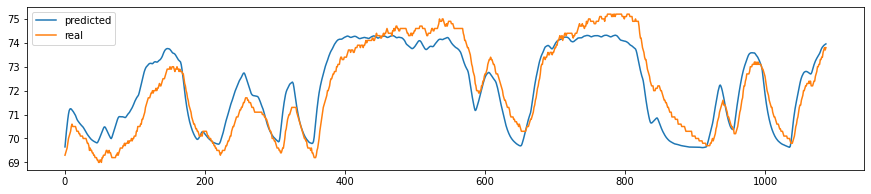

In [11]:
print("R2: ", r2_score(Tz_1[0:n,0], T))

plt.figure(figsize=(15,3))
plt.plot(T, label='predicted')
plt.plot(Tz_1[0:n, 0], label='real')
plt.legend()
plt.show()

In [17]:
def func_test_R2(model, Tz_0, Tz_1, Tsa_1, msa_1, steps):
    Tz0  =  Tz_0[0].reshape(-1,1)
    T = np.array([])
    for i in range(steps):
        with torch.no_grad():
            # COMPUTE
            x1 = torch.tensor(np.copy(Tsa_1[i]).reshape(-1,1), dtype=torch.float32)
            x2 = torch.tensor(Tz0, dtype=torch.float32)
            x3 = torch.tensor(np.copy(msa_1[i]).reshape(-1,1), dtype=torch.float32)
            Tz1 = model(x1, x2, x3)

            # UPDATE
            Tz0 = np.copy(Tz1).reshape(-1,1)

            # save Tz
            T = np.append(T, Tz1)
    return r2_score(Tz_1[0:steps, 0], T)

In [18]:
func_test_R2(Tz, Tz_0, Tz_1, Tsa_1, msa_1, 1000)

0.8073933168591809